In [ ]:
! pip install tensorflow tensorflow.keras

import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import PIL
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense




[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.20.0-cp313-cp313-win_amd64.whl.metadata (4.6 kB)
Using cached tensorflow-2.20.0-cp313-cp313-win_amd64.whl (332.0 MB)


In [2]:
batch_size = 32
img_height, img_width = 224, 224

# Load the Data set

In [3]:
lab_dataset = "../data/leafsnap-dataset/dataset/images/lab"

# Split the data set (images) into training and validation set

In [4]:
# Create training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  lab_dataset,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 23147 files belonging to 185 classes.
Using 18518 files for training.


In [5]:
# Create validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  lab_dataset,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)


Found 23147 files belonging to 185 classes.
Using 4629 files for validation.


# Data augmentation

In [6]:

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
])

# class names

In [7]:
class_names = train_ds.class_names
print(class_names)

['abies_concolor', 'abies_nordmanniana', 'acer_campestre', 'acer_ginnala', 'acer_griseum', 'acer_negundo', 'acer_palmatum', 'acer_pensylvanicum', 'acer_platanoides', 'acer_pseudoplatanus', 'acer_rubrum', 'acer_saccharinum', 'acer_saccharum', 'aesculus_flava', 'aesculus_glabra', 'aesculus_hippocastamon', 'aesculus_pavi', 'ailanthus_altissima', 'albizia_julibrissin', 'amelanchier_arborea', 'amelanchier_canadensis', 'amelanchier_laevis', 'asimina_triloba', 'betula_alleghaniensis', 'betula_jacqemontii', 'betula_lenta', 'betula_nigra', 'betula_populifolia', 'broussonettia_papyrifera', 'carpinus_betulus', 'carpinus_caroliniana', 'carya_cordiformis', 'carya_glabra', 'carya_ovata', 'carya_tomentosa', 'castanea_dentata', 'catalpa_bignonioides', 'catalpa_speciosa', 'cedrus_atlantica', 'cedrus_deodara', 'cedrus_libani', 'celtis_occidentalis', 'celtis_tenuifolia', 'cercidiphyllum_japonicum', 'cercis_canadensis', 'chamaecyparis_pisifera', 'chamaecyparis_thyoides', 'chionanthus_retusus', 'chionanthu

# plot some images and class names

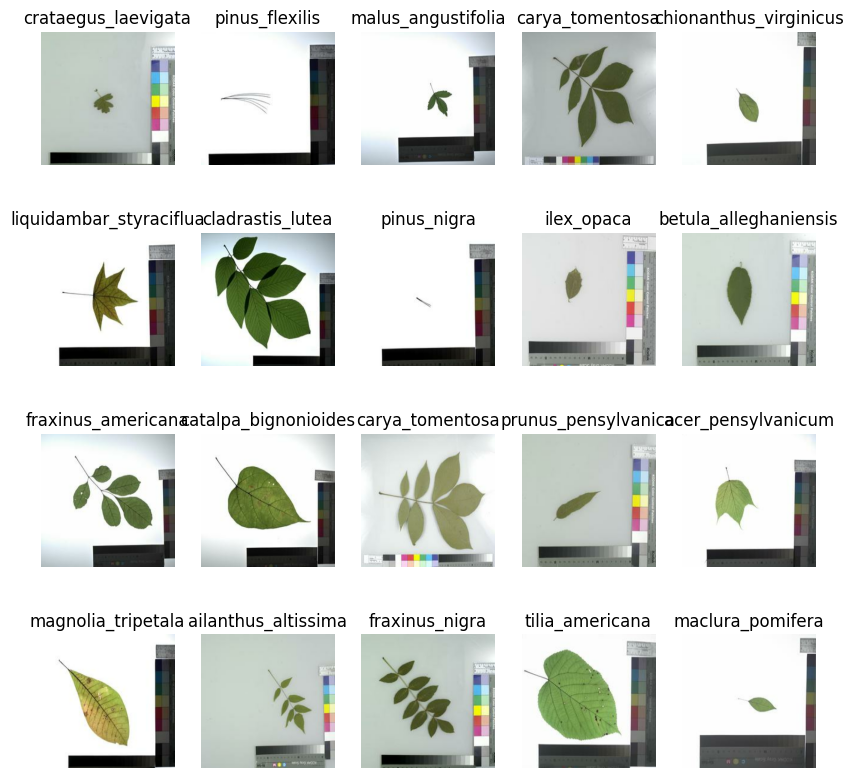

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(20):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

# batches of images

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


# standardize the data

In [10]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


# Configure the dataset for performance

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model Training

The Sequential model consists of three convolution blocks with a max pooling layer in each of them. There's a fully-connected layer with 128 units on top of it that is activated by a ReLU activation function ('relu'). This model has not been tuned in any way—the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit the Image classification tutorial.

In [ ]:
num_classes = len(class_names)

scratch_model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(244, 244, 3)),  # input layer
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # output layer
])


# defining optimizers and loss functions

In [13]:
scratch_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
  )

# add early stopping

In [ ]:

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# train the model with 3 epochs

In [ ]:
num_epochs = 10
history = scratch_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=num_epochs,
  callbacks=[early_stopping]
)

Epoch 1/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 302s 519ms/step - accuracy: 0.3686 - loss: 2.5533 - val_accuracy: 0.6217 - val_loss: 1.1956
Epoch 2/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 319s 550ms/step - accuracy: 0.7032 - loss: 0.9089 - val_accuracy: 0.7280 - val_loss: 0.8474
Epoch 3/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 332s 573ms/step - accuracy: 0.8038 - loss: 0.5694 - val_accuracy: 0.7570 - val_loss: 0.7794
Epoch 4/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 342s 590ms/step - accuracy: 0.8642 - loss: 0.3930 - val_accuracy: 0.7667 - val_loss: 0.8173
Epoch 5/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 299s 515ms/step - accuracy: 0.8955 - loss: 0.2965 - val_accuracy: 0.7747 - val_loss: 0.8782
Epoch 6/10
 77/579 ━━━━━━━━━━━━━━━━━━━━ 5:08 614ms/step - accuracy: 0.9057 - loss: 0.2524

In [ ]:
scratch_model.evaluate(val_ds)
scratch_model.summary()


145/145 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.7609 - loss: 0.7788


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,769,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 185)            │        23,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,436,845 (32.18 MB)

 Trainable params: 2,812,281 (10.73 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,624,564 (21.46 MB)

TypeError: Model.save() missing 1 required positional argument: 'filepath'

# Using Transfer learning model to compare results

### preprocessing

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping




In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


# Model Development

In [ ]:
base_model = MobileNetV2(input_shape=(224,224,3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # freeze base model

inputs = tf.keras.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

In [ ]:

transferLearning_model = models.Model(inputs, outputs)

# 5. Compile model
transferLearning_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 6. Train model
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = transferLearning_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 640s 1s/step - accuracy: 0.3776 - loss: 2.6944 - val_accuracy: 0.6092 - val_loss: 1.5024
Epoch 2/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 506s 874ms/step - accuracy: 0.6361 - loss: 1.3143 - val_accuracy: 0.6839 - val_loss: 1.1043
Epoch 3/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 733s 1s/step - accuracy: 0.7126 - loss: 1.0104 - val_accuracy: 0.7153 - val_loss: 0.9565
Epoch 4/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7365 - loss: 0.9038

In [ ]:
transferLearning_model.evaluate(val_ds)

145/145 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.7609 - loss: 0.7788


[0.7788097262382507, 0.760855495929718]